<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/T5_ftransfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
import progressbar
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill


!pip install transformers -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


     |████████████████████████████████| 778kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 28kB/s eta 0:00:0101
     |████████████████████████████████| 890kB 19.7MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 26.5MB/s eta 0:00:01


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .

#from optimizers import AdaFactor

In [ ]:
# !nvidia-smi
# !/usr/local/cuda/bin/nvcc --version

Wed Jul 15 14:31:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


#### Getting dataset

You can find the dataset [here](https://github.com/mahnazkoupaee/WikiHow-Dataset)

**Loading data**

In [3]:
with open('./wikihowAll.csv') as f:
  wikihowAll = pd.read_csv(f)
print(f'The size of data:{wikihowAll.shape}')

The size of data:(215365, 3)


In [4]:
wikihowAll.head(2)

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...


In [5]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [6]:
wikihowAll.isnull().sum()

headline     818
title          1
text        1071
dtype: int64

we have 818 articles without summaries

In [7]:
new_wikihowAll = wikihowAll[['text', 'headline']]
new_wikihowAll = new_wikihowAll.dropna(how='all')

In [8]:
new_wikihowAll.isnull().sum()

text        253
headline      0
dtype: int64

In [9]:
indices = np.where(new_wikihowAll['text'].isna())

In [10]:
new_wikihowAll.iloc[indices]

,text,headline
1492,NaN,Colour coordinate your looks (For all Events)\n\n
4328,NaN,\nRecognize the following symptoms:\n\nBloatin...
7190,NaN,"\nAt each practice, teach all of your squad di..."
7228,NaN,Understand that these directions assume the re...
7378,NaN,"Dribble with your left or right hand, whicheve..."
...,...,...
208605,NaN,\nStretch each arm as far across your chest wh...
210787,NaN,\nDownshift to a lower gear to get more power ...
212574,NaN,\nThe next thing you need to do is show Invisi...
213977,NaN,"\nIt is the same as the chorus, but with the s..."


In [11]:
new_wikihowAll = new_wikihowAll.dropna().reset_index(drop=True)
new_wikihowAll.isnull().sum()

text        0
headline    0
dtype: int64

In [12]:
new_wikihowAll.shape

(214294, 2)

In [ ]:
# h = new_wikihowAll

# for x in ['text', 'headline']:
# 		h[x+'_tokenized'] = h[x].apply(lambda x:x.lower().split() );
# 		h[x+'_len'] = h[x+'_tokenized'].apply(lambda x: len(x))
# min(h['headline_len']), min(h['text_len']), len(h[h['headline_len']==1]), len(h[h['text_len']==0])

#####Preprocessing

In [13]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    
    line = line.lower() 
    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.replace('-', ' ')
    line = line.strip(' ')
    line = re.sub(r'\s{2,}',' ', line)

    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [14]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction
    #self.textproc = textproc

  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['headline', 'text']
      data_dict = {}
      good = []

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        if title == 'headline':    
          for tt in res:
            row = ' '.join(tt.split('\n'))
            good.append(row.strip())
        data_dict[title] = res

      dd = pd.DataFrame(good)
      dd.columns = ['headline']
      ss = pd.DataFrame(data_dict)
      ss = ss.drop(columns='headline', axis=1)
      dataset = pd.concat([ss, dd], axis=1)
      
      return dataset

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['headline'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      max_len, dataframe = self.get_max_tokens(dataframe)
    else:
      max_len = self.max_length

    min_length = max_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe)):
        pragraph = len(paragraph.split())
        if pragraph <= min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    _, final_data = self.get_max_tokens(final_data)


    print('Done!')
    return final_data, max_len

In [15]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 30,
          'min_summary_tokens': 0}

In [16]:
textproc = Processor(new_wikihowAll,contraction)#, maxlen)
dataset, max_len = textproc.cleaned_data()

Please wait, we are cleaning...



Done!


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214294 entries, 0 to 214293
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         214294 non-null  object
 1   headline     214294 non-null  object
 2   article_len  214294 non-null  int64 
 3   summary_len  214294 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.5+ MB


In [ ]:
max_len

{'max_article_tokens': 12394,
 'max_summary_tokens': 4341,
 'min_article_tokens': 0,
 'min_summary_tokens': 1}

In [ ]:
dataset['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      44.0000
0.7500      77.0000
0.9000     122.0000
0.9500     159.0000
0.9900     266.0000
0.9990     503.0000
0.9999    1024.9796
Name: summary_len, dtype: float64

In [ ]:
dataset['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     306.0000
0.7500     550.0000
0.9000    1049.0000
0.9500    1484.0000
0.9900    2364.0700
0.9990    3665.1210
0.9999    5201.5503
Name: article_len, dtype: float64

In [ ]:
art = int(dataset['article_len'].quantile(0.9900))
sum = int(dataset['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum}')

art len:2364, sum len:266


#### Creating Custom Dataset

In [17]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, **kwargs):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.articles = dataframe.text
    self.summary  = dataframe.headline
    self.source_len = kwargs.get('max_article_tokens', 512)
    self.target_len = kwargs.get('max_summary_tokens', 150)
  
  def __len__(self):
    return len(self.articles)

  def __getitem__(self, idx):
    articles = self.articles[idx]
    articles = ' '.join(articles.split())

    summary = self.summary[idx]
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


#### Training Loop

In [18]:
def training(model, dataset_loader, optimizer, iteration=0):

  model.train()
  avg_loss = 0
  nItem = 0


  print(f'Start training for epoch: {iteration}')
 
  for idx, data_train in enumerate(dataset_loader):

    input_ids, source_mask, summary_ids, summary_mask = data_train

    input_ids = input_ids.to(device, dtype = torch.long)
    source_mask = source_mask.to(device, dtype = torch.float)
    summary_ids = summary_ids.to(device, dtype = torch.long)

    target_labels = summary_ids[:, :-1].contiguous()
    langm_labels = summary_ids[:, 1:].clone().detach()
    langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

    optimizer.zero_grad()
    
    output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, output_hidden_states=True)
    
    loss = output[0]

    loss.backward()
    optimizer.step()

    bs = input_ids.size(0)
    nItem += bs

    avg_loss += loss.item() * bs
    if idx % 100 == 0:
      print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
  
  avg_loss /= nItem
  
  return avg_loss, output


In [19]:
def validation(model, dataset_loader):
  model.eval()

  eval_loss = 0
  nItem = 0

  with torch.no_grad():
    for idx, data_val in tqdm(enumerate(dataset_loader)):

      input_ids, source_mask, summary_ids, summary_mask = data_val

      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      target_labels = summary_ids[:, :-1].contiguous()
      langm_labels = summary_ids[:, 1:].clone().detach()
      langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100
      
      output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels)
      
      loss = output[0]

      bs = input_ids.size(0)
      nItem += bs

      eval_loss += loss.item()

    eval_loss /= nItem

    return eval_loss

In [20]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [21]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [22]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = AdaFactor(model.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

model = model.to(device)

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at t5-base and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [23]:
#@title Train, Validation and Test splits { run: "auto" }

eos = ' </s>'  #tokenizer.eos_token
sos = '<pad> ' #tokenizer.pad_token

dataset.text = "summarize: " + dataset.text + eos # for T5 conformity
dataset.headline = sos + dataset.headline + eos
columns = ["text","headline"]

df = dataset[columns]
X_train, X_val = train_test_split(df, test_size=0.1, random_state = 42)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [24]:
X_train.head()

,text,headline
0,summarize: this calendar of events is availabl...,"<pad> consult the formula 1 race calendar., pi..."
1,summarize: once you ve finished your self anal...,"<pad> fix the problem., make a conscious effor..."
2,summarize: stir it thoroughly and then set it ...,<pad> add 1 teaspoon 4.9 ml of borax to 500 mi...
3,summarize: recognizing that you need to establ...,"<pad> decide to set boundaries., define the bo..."
4,summarize: communicate with your significant o...,<pad> talk with your significant other about y...


In [ ]:
# train_size = 0.8
# train_dataset=df.sample(frac=train_size, random_state = SEED).reset_index(drop=True)
# val_dataset=df.drop(train_dataset.index).reset_index(drop=True)

In [ ]:
#d = ' '.join(X_train.iloc[0]['text'].split())
#d

In [ ]:
#d = ' '.join(X_train.iloc[0]['headline'].split())
#d

In [42]:
X_test = X_val.iloc[:12]

In [25]:
X_train = X_train.iloc[:2000]
X_val = X_val.iloc[:600]

In [43]:
args = {'max_article_tokens': 512,
          'max_summary_tokens': 150}

train_set = CustomDataReader(X_train, tokenizer,**args)
val_set = CustomDataReader(X_val, tokenizer,**args)

test_set = CustomDataReader(X_test, tokenizer,**args)

In [44]:
BATCH_SIZE = 4
train_params = {
        'batch_size': BATCH_SIZE,
        'shuffle': True,
        'num_workers': 2
        }

val_params = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': 2
    }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

test_loader = DataLoader(test_set, **val_params)

In [28]:
N_EPOCHS = 15
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
filename = open(pcle, 'wb')

In [37]:
def run(N_EPOCHS, model, train_loader, val_loader, optimizer, path, filename=None, lr= LEARNING_RATE):

  #best_loss = float('inf')
  best_pp = float('inf')

  train_loss = []
  val_loss = []
  perplexity = []

  for epoch in range(N_EPOCHS):

    avg_loss, outputs = training(model, train_loader, optimizer, iteration=epoch)
    print('\nValidation start:')
    eval_loss = validation(model, val_loader)
    
    pp = get_perplexity(eval_loss)
    
    perplexity.append(pp)
    train_loss.append(avg_loss)
    val_loss.append(eval_loss)
    scheduler.step(eval_loss)

    
    print(f'Epoch loss: {avg_loss:.2f}')
    print(f'Perplexity: {pp:.3f} | Eval loss: {eval_loss:.2f}')
    print("--------------")


#     if pp < best_pp:
#       best_pp = pp
#       saving(path, epoch, avg_loss, model, pp, lr)
#       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
#   print(f'Best Perplexity: {best_pp}')
#   filename.close()

  return train_loss, perplexity, val_loss, outputs

In [38]:
train_loss, perplexity, eval_loss, outputs = run(N_EPOCHS, model, train_loader, val_loader, optimizer, path)

Start training for epoch: 0
[0/2000 (0)%] 	 Training loss: 5.775
[400/2000 (20)%] 	 Training loss: 2.769
[800/2000 (40)%] 	 Training loss: 2.865
[1200/2000 (60)%] 	 Training loss: 2.993
[1600/2000 (80)%] 	 Training loss: 2.402

Validation start:



Epoch loss: 2.58
Perplexity: 1.815 | Eval loss: 0.60
--------------
Start training for epoch: 1
[0/2000 (0)%] 	 Training loss: 2.229
[400/2000 (20)%] 	 Training loss: 2.472
[800/2000 (40)%] 	 Training loss: 2.163
[1200/2000 (60)%] 	 Training loss: 2.898
[1600/2000 (80)%] 	 Training loss: 2.314

Validation start:



Epoch loss: 2.16
Perplexity: 1.821 | Eval loss: 0.60
--------------
Start training for epoch: 2
[0/2000 (0)%] 	 Training loss: 1.659
[400/2000 (20)%] 	 Training loss: 1.838
[800/2000 (40)%] 	 Training loss: 1.997
[1200/2000 (60)%] 	 Training loss: 1.469
[1600/2000 (80)%] 	 Training loss: 2.153

Validation start:



Epoch loss: 1.79
Perplexity: 1.839 | Eval loss: 0.61
--------------
Start training for epoch: 3
[0/2000 (0)%] 	 Training loss: 1.448
[400/2000 (20)%] 	 Training loss: 1.604
[800/2000 (40)%] 	 Training loss: 1.868
[1200/2000 (60)%] 	 Training loss: 1.847
[1600/2000 (80)%] 	 Training loss: 1.125

Validation start:



Epoch loss: 1.54
Perplexity: 1.869 | Eval loss: 0.63
--------------
Start training for epoch: 4
[0/2000 (0)%] 	 Training loss: 1.183
[400/2000 (20)%] 	 Training loss: 1.388
[800/2000 (40)%] 	 Training loss: 1.599
[1200/2000 (60)%] 	 Training loss: 1.151
[1600/2000 (80)%] 	 Training loss: 2.156

Validation start:



Epoch loss: 1.43
Perplexity: 1.908 | Eval loss: 0.65
--------------
Start training for epoch: 5
[0/2000 (0)%] 	 Training loss: 0.760
[400/2000 (20)%] 	 Training loss: 0.882
[800/2000 (40)%] 	 Training loss: 1.249
[1200/2000 (60)%] 	 Training loss: 1.414
[1600/2000 (80)%] 	 Training loss: 1.538

Validation start:



Epoch loss: 1.35
Perplexity: 1.930 | Eval loss: 0.66
--------------
Start training for epoch: 6
[0/2000 (0)%] 	 Training loss: 1.245
[400/2000 (20)%] 	 Training loss: 2.029
[800/2000 (40)%] 	 Training loss: 1.423
[1200/2000 (60)%] 	 Training loss: 1.828
[1600/2000 (80)%] 	 Training loss: 1.392

Validation start:



Epoch loss: 1.32
Perplexity: 1.939 | Eval loss: 0.66
--------------
Start training for epoch: 7
[0/2000 (0)%] 	 Training loss: 1.164
[400/2000 (20)%] 	 Training loss: 1.555
[800/2000 (40)%] 	 Training loss: 1.210
[1200/2000 (60)%] 	 Training loss: 0.723
[1600/2000 (80)%] 	 Training loss: 1.419

Validation start:



Epoch loss: 1.30
Perplexity: 1.942 | Eval loss: 0.66
--------------
Start training for epoch: 8
[0/2000 (0)%] 	 Training loss: 1.406
[400/2000 (20)%] 	 Training loss: 1.654
[800/2000 (40)%] 	 Training loss: 1.533
[1200/2000 (60)%] 	 Training loss: 1.145
[1600/2000 (80)%] 	 Training loss: 1.656

Validation start:



Epoch loss: 1.30
Perplexity: 1.945 | Eval loss: 0.67
--------------
Start training for epoch: 9
[0/2000 (0)%] 	 Training loss: 1.075
[400/2000 (20)%] 	 Training loss: 1.785
[800/2000 (40)%] 	 Training loss: 1.165
[1200/2000 (60)%] 	 Training loss: 1.533
[1600/2000 (80)%] 	 Training loss: 1.034

Validation start:


[400/2000 (20)%] 	 Training loss: 1.453
[800/2000 (40)%] 	 Training loss: 1.693
[1200/2000 (60)%] 	 Training loss: 1.443
[1600/2000 (80)%] 	 Training loss: 1.489

Validation start:



Epoch loss: 1.29
Perplexity: 1.947 | Eval loss: 0.67
--------------
Start training for epoch: 13
[0/2000 (0)%] 	 Training loss: 1.326
[400/2000 (20)%] 	 Training loss: 1.135
[800/2000 (40)%] 	 Training loss: 1.213
[1200/2000 (60)%] 	 Training loss: 0.985
[1600/2000 (80)%] 	 Training loss: 1.518

Validation start:



Epoch loss: 1.29
Perplexity: 1.947 | Eval loss: 0.67
--------------
Start training for epoch: 14
[0/2000 (0)%] 	 Training loss: 1.120
[400/2000 (20)%] 	 Training loss: 1.451
[800/2000 (40)%] 	 Training loss: 1.718
[1200/2000 (60)%] 	 Training loss: 1.592
[1600/2000 (80)%] 	 Training loss: 1.141

Validation start:



Epoch loss: 1.29
Perplexity: 1.947 | Eval loss: 0.67
--------------
Best Perplexity: inf


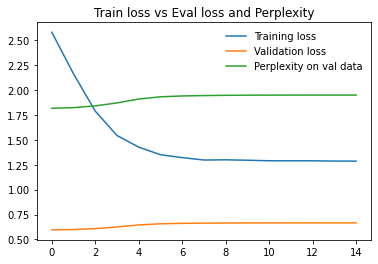

In [39]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [62]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:
    
    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [63]:
%time results = generator(model, test_loader)

CPU times: user 20.9 s, sys: 519 ms, total: 21.4 s
Wall time: 20.9 s


#### Visualizing examples

**Example 1**

In [64]:
X_test.iloc[0,:]['text']

'summarize: , this may be represented by a symbol representing a diode, an arrow pointing at a vertical line. ,, place the red probe on the positive side of the diode and the black probe on the negative side. if you get a reading of less than 1 but more than 0, the forward bias is good. , if the display reads ol overload , this indicates that reverse bias is good. , some multimeters will beep when the reading is less than 1. this doesn t necessarily indicate a good diode, because a shorted diode will also cause a beep.  </s>'

In [65]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'insert the black probe into the common terminal and the red probe into the terminal marked for measuring ohms, volts or diode test., use the selector knob to choose the test diode function., turn the power off to the circuit., test forward bias., reverse the probes to test reverse bias., a reading of ol or 0 while testing forward bias, and 0 while testing reverse bias indicates that the diode is bad.'

In [66]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'look for a diode., select the diometer you want to test., check your display and see how it reads., use polarizers on both sides of the multimeter until you get 0 or higher reading values than 1. if you have fewer probe positions then this indicates inverse bias.'

**Example 2**

In [76]:
X_test.iloc[2,:]['text']

'summarize: thumping on the floor as you approach the puppy will usually work, since even deaf animals can feel vibrations. flicking the light switch on and off is another option. a flashlight is useful if you let your dog into an enclosed yard at night and need to call it back.vibrating collars are available that will let you get the dog s attention with a remote control. these tools are only useful once the dog has learned some basic training and responds to your command, especially because it takes the dog additional training to get used to the collar in the first place. , because your deaf puppy won t get any encouragement from the tone of your voice, food will be even more important during training than it is for other dogs. find a source of healthy treats that you can provide constantly throughout the day, without giving the dog more than 10 of its calories for the day. asking the vet is the best way to find a store bought treat formulated for your dog s needs, but here are a few

In [77]:
print("Actual summary:")
results['golden_summary'][2]

Actual summary:


'learn how to get the dog s attention., find healthy dog treats., make the dog comfortable with being touched., keep the dog on a leash while outdoors., consider getting a pocket sign language book., pick a good training treat., understand clicker training for deaf dogs., give the command to sit., get the dog to sit down., show the visual marker and give a treat., repeat for a few minutes., train two or three times a day., continue training., teach it more commands.'

In [78]:
print('Generated summary:')
results['generated_summary'][2]

Generated summary:


'use a vibrating collar., feed the dog healthy treats throughout each day instead of feeding them full meals or treats at mealtimes with no penalty for injury or illness.thump the floor as you approach your deaf puppy to calm down after training.you can also use touch and gesture therapy in order get this dog used quickly enough to respond appropriately when asked by someone else during an emergency situation while walking into confined spaces indoorly but without distraction from its surroundings!'

**Example 3**

In [67]:
X_test.iloc[10,:]['text']

'summarize: marshmallows are very sticky, so you need to start with a greased pan. spray down a 9 by 13 inch pan 23 centimeters by 33 centimeters with cooking spray. it can also help to spray down any utensils you re going to use. the mixture will stick to anything., mix the packets of gelatin with about half a cup 125 milliliters of water and the vanilla extract in the bowl of a stand mixer. just use a fork to mix them together. let the mixture sit to the side for a few minutes so the gelatin can bloom hydrate .try to get all the lumps out with the fork.\nyou can also use extracts like raspberry, lemon, orange, almond, or banana, depending on what you want to do with the marshmallows. , add 1 2 cup 125 milliliters of water to a small pan. pour in the sugar or the sugar plus the corn syrup, whichever you re using. bring it to a boil over medium to high heat, and let it boil until it reaches 250 degrees fahrenheit 121 degrees celsius or just under. continually wipe down the insides of t

In [68]:
print("Actual summary:")
results['golden_summary'][10]

Actual summary:


'grease the pan., hydrate the gelatin., make the simple syrup., mix the gelatin in.'

In [69]:
print('Generated summary:')
results['generated_summary'][10]

Generated summary:


'grease a pan., mix the gelatin and water with vanilla extracts in tin canisters or a stand mixer bowl on medium high heat until smooth.the mixture will stick to anything you use.you can also use corn syrup for some marshmallow making too much of the mixture crystallize when heated up.your marshmallows should be soft enough to handle without the syrup.if your marshmallow is very sticky, make sure it sticks to the pan.'

**Example 4**

In [70]:
X_test.iloc[3,:]['text']

'summarize: now download the setup for your operating system by clicking on the link right besides the package name. for this article, i have downloaded, virtualbox 4.3.16 for windows hosts. make sure you download the latest version of virtualbox for your operating system. i am presently working on windows 8.1. ,,, if you like to place a shortcut icon for virtualbox on your desktop and in the quick launch bar, leave the first two boxes selected. ,\xa0this will help you to access internet and other network resources from windows 10. , now sit back and chillax while virtualbox installs on your system. depending on the security settings on your operating system and available system drivers, your operating system may ask you to allow or deny the setup proceed and install few drivers. this is essential for your virtualbox to let windows 10 access hardware and other resources on your host operating system the operating system you are using right now . you may choose to accept and install the

In [71]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'visit and look for a list of virtualbox platform packages., run the setup file you downloaded and click on next., on the custom setup screen, you can leave the settings as it is and proceed by clicking on the next button., leave the register file associations selected and click on next., now click on yes to ensure that virtualbox is able to access your network interfaces., click on install., once virtualbox has been installed on your system, you can then select, start oracle vm virtualbox if not already selected and then click on finish., after the virtualbox opens up, minimize it or keep it open., to download an official copy of windows 10'

In [72]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'download the virtualbox setup for your operating system., click on start virtual box now to start installing windows 10 on your computer. if you want to access network resources from your desktop, click on shortcut icon in the left pane of windows 10. i have downloaded and installed virtualbost 4.3.996 for windows hosts as it is an open source package available at this point. a second step will be to select the virtual machine you are working with., after selecting the virtual device, click on install now to start installation process., once you have downloaded all necessary information about how to join our virtualdisk program, go into the launch bar and navigate through the menu under virtual boxes., when you arrive at the top right corner that appears, choose whether or not you wish to install any drivers automatically installed.'

######Performance

In [56]:
!pip install rouge
from rouge import Rouge

In [57]:
rouge = Rouge()

In [83]:
refs = results['golden_summary'][0]
hyps = results['generated_summary'][0]
score = rouge.get_scores(hyps, refs, avg=True)

In [84]:
score

{'rouge-1': {'f': 0.2968749952062989,
  'p': 0.37254901960784315,
  'r': 0.24675324675324675},
 'rouge-2': {'f': 0.04761904283194807, 'p': 0.06, 'r': 0.039473684210526314},
 'rouge-l': {'f': 0.31111110611358034,
  'p': 0.30434782608695654,
  'r': 0.3181818181818182}}

In [ ]:
def metric(labels, gen_target):
  print(f'Start evaluation')
  bar = progressbar.ProgressBar(maxval=len(dataset_loader))
  bar.start()
  


  bar.finish()


##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])